# Мониторинг качества моделей

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score

from keras.models import load_model

In [2]:
# Загрузим лучшие модели

with open('models/model_lgb.pkl', 'rb') as f:
    model_lgb = pickle.load(f)

model_nn = load_model('models/model_nn_6.h5')

In [3]:
# Загрузим данные

df_test = pd.read_csv('data/test_data_with_scores.csv')

In [4]:
feature_columns = [
    'Client_age', 'Gender', 'Numb_of_Prod', 'Salary',
    'HasCrCard', 'Numb_of_years', 'CreditScore', 'Balance', 'IsActiveMember',
]
target_col = 'res'

In [5]:
# Будем перемешивать признаки в датасете в порядке повышения их важности

features = ['HasCrCard', 'Salary', 'Numb_of_years', 'Gender', 'IsActiveMember', 'Numb_of_Prod', 'Balance', 'Client_age', 'CreditScore']

auc_lgb = [roc_auc_score(df_test[target_col], df_test['model_log_score_calib_kfold'])]
auc_nn = [roc_auc_score(df_test[target_col], df_test['model_nn_6_score_calib'])]
for i in range(len(features)):

    feats = features[:i]

    df_for_importance = df_test.copy()
    df_for_importance[feats] = np.random.permutation(df_for_importance[feats].values)

    df_for_importance['metric_lgb'] = model_lgb.predict_proba(df_for_importance[feature_columns])[:, 1]
    df_for_importance['metric_nn'] = model_nn.predict(df_for_importance[feature_columns])[:, 1]

    auc_lgb.append(roc_auc_score(df_for_importance[target_col], df_for_importance['metric_lgb']))
    auc_nn.append(roc_auc_score(df_for_importance[target_col], df_for_importance['metric_nn']))

158/158 [==============================] - 1s 4ms/step


__Построим график мониторинга моделей при ухудшении их работоспособности__

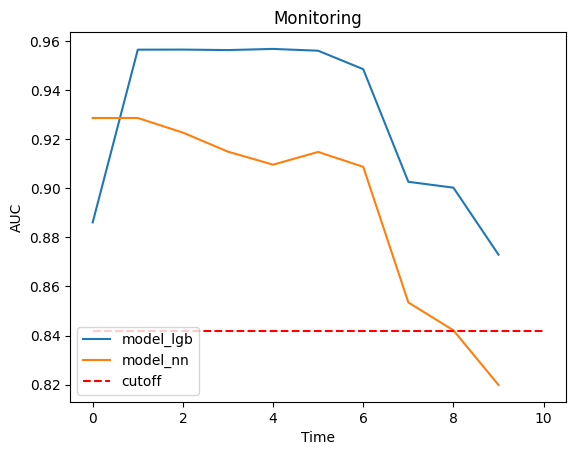

In [7]:
cutoff = min([auc_lgb[0], auc_nn[0]]) - min([auc_lgb[0], auc_nn[0]]) * 0.05 # Модель стоит переобучать при ухудшении метрики на 5%
end = len(auc_nn)

fig = plt.figure()
plt.plot(auc_lgb, label='model_lgb')
plt.plot(auc_nn, label='model_nn')
plt.plot([0, end], [cutoff, cutoff], '--', color='red', label='cutoff')
plt.title('Monitoring')
plt.xlabel('Time')
plt.ylabel('AUC')
plt.legend(loc='lower left')
fig.savefig('docs/Monitoring.pdf')